# Mode-Turbulence Coupling: Numerical Analysis
# Plots for paper

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate
from scipy.integrate import RK45
import statistics

### Physical Parameters

In [2]:
# mach number Ma
Ma = 0.1
K = 1

Q = 0.1
q = 1

### Functions of Ma

In [3]:
meandeltaT = 2*np.pi / Ma

# variables for generating F1
meanF1 = 0
stdF1 = Ma**3 / (2 * np.pi)
limitF1 = 1 / (2 * np.pi)

### Calculation parameters

In [4]:
L = 10
Tmax = 10**3
N = 1
m = 100

Tr = K * meandeltaT

### Calculation relations

In [5]:
# Tmax = 2 * pi * M
# delt = N * deltaT

### Initial Conditions

In [6]:
# initial conditions A(0)=1/2*std_F2, dA/dT(0)=0
initial_dAdT = 0
initial_AT = 0.1

In [7]:
n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

### Functions

In [8]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(meandeltaT, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()

# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html
#deltaT is the length of each eddy turnover
def fundeltaT(n_bins, Tmax):
    rayleigh = np.random.rayleigh(meandeltaT, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(100)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's
def funTturb():
    Tturb = [0]
    for i in range(len(deltaT) - 1):
        Tturb.append(deltaT[i] + Tturb[i])
    time = Tturb
    time.pop(-1)
    return Tturb, time

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2 + (deltaT[i+1])/2)
    return t

def funAmp(dAdT, AT):
    #A is the amplitude
    A=[]
    #t is time
    t=[]

    for i in range(len(Tturb)-1):
        #Ttemp is an array containing the times between each eddy turnover 
        #(which starts at 0 and ends at deltaT)
        Ttemp=np.linspace(0, deltaT[i])
        
        #this for loop below loops through each eddy turnover:
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(Tturb[i]+j)
                A.append(AT * math.cos(j) * math.exp(- (Q / (2*q) * math.sin(q * j))))
        #resets the initial conditions for the next eddy turnovers to match the conditions at the end of the previous eddy turnover
        AT=A[-1]
            
    return A, t

# Average value of Amplitude
def FunAsqr(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    return Asqr

# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

# Root mean square
def FunRMS(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = np.sum(Asqr) / len(Asqr)
    RMS = avg**(1/2)
    return RMS
    

In [9]:
def Funplots(t, A, f1, f2):

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, A, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.ticker.ScalarFormatter(set_scientific(self, b))
    #plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
    #plt.rcParams['font.size']=7
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()

### Parameters

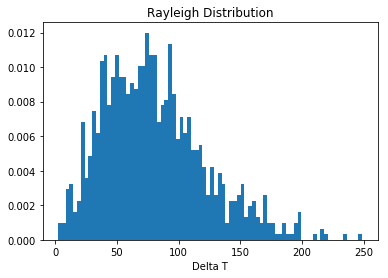

In [10]:
rayleighdistribution()

deltaT = fundeltaT(n_bins, Tmax)

Tturb, time = funTturb()

t = funt()

##  Amplitude of mode, F1, F2, log(A) vs. Time

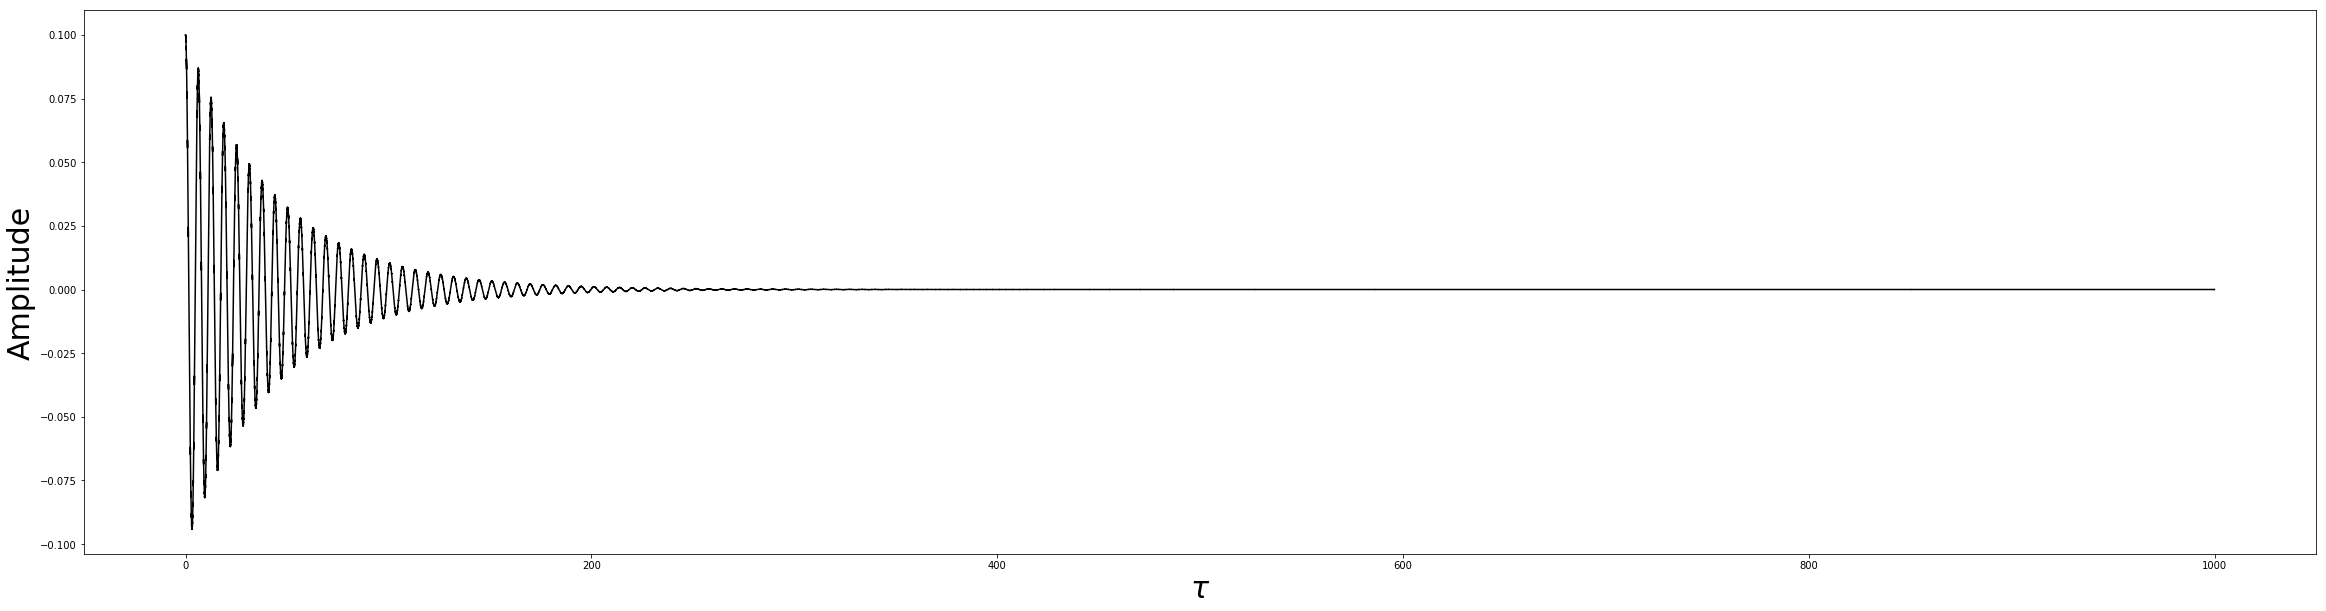

In [13]:
# Runge Kutta

# A = A0 * cos (T) * exp( - (Q/2*q) * sin(q*T) )
# A' = B
# B' = f(T, A, B) = - F1(T) * B - A
# A(0) = 0.1
# A'(0) = B = 0

A = 0.1

t = 0.0
B = 0 

#time step dT
dT = 0.01

Atest=[]
Ttest=[]

while ( t < Tmax ):
    Atest.append(A)
    Ttest.append(t)
    m1 = B
    k1 = - Q * math.cos(q*t) * B - A
    m2 = B + ( dT / 2.) * k1
    t_2 = t + (dT / .2)
    Ttest.append(t_2)
    A_2 = A + (dT / .2) * m1
    Atest.append(A_2)
    B_2 = m2
    k2 = - Q * math.cos(q*t_2) * B_2 - A_2
    m3 = B + (dT / .2) * k2
    t_3 = t + (dT / .2)
    Ttest.append(t_3)
    A_3 = A + (dT / .2) * m2
    Atest.append(A_3)
    B_3 = m3
    k3 = - Q * math.cos(q*t_3) * B_3 - A_3
    m4 = B + dT *k3
    t_4 = t + dT
    Ttest.append(t_4)
    A_4 = A + dT * m3
    Atest.append(A_4)
    B_4 = m4
    k4 = - Q * math.cos(q*t_4) * B_4 - A_4
    t = t + dT
    A = A + (dT / 6.) * (m1 + (2. * m2) + (2. * m3) + m4)
    B = B + (dT / 6.) * (k1 + (2. * k2) + (2. * k3) + k4)

plt.figure(figsize=(40,10))
plt.plot(Ttest, Atest, 'k')
plt.xlabel(r'$\tau$', **axis_font)
plt.ylabel('Amplitude', **axis_font)
plt.show()

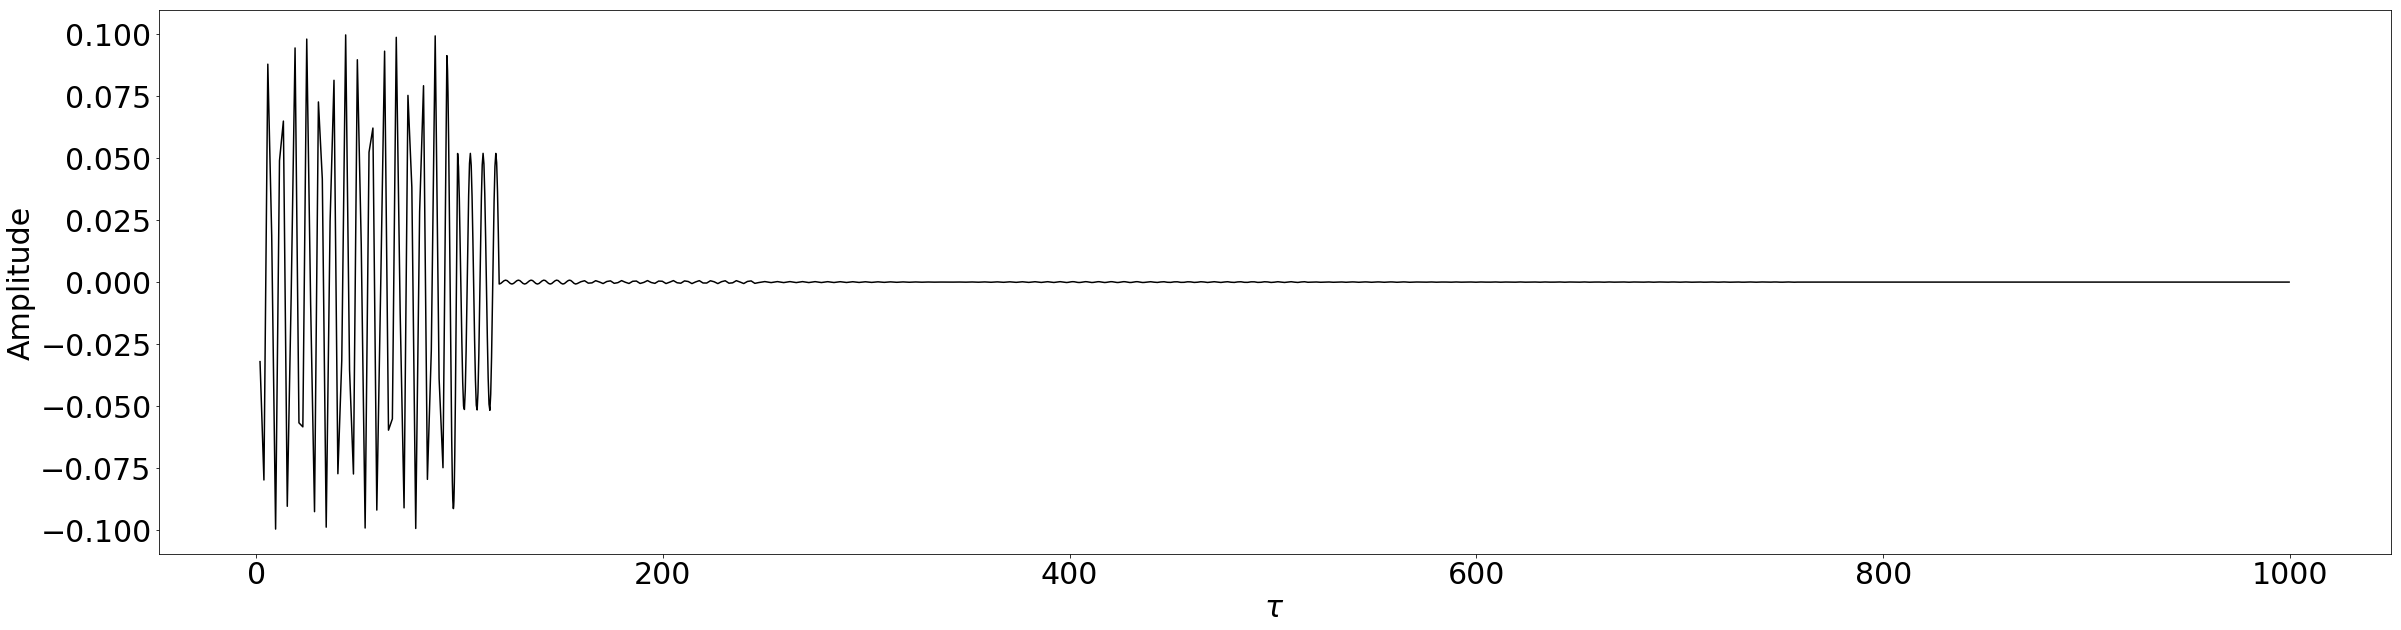

T(max) = 1000


In [12]:
plt.figure(figsize=(40,10))
A, t =funAmp(initial_dAdT, initial_AT)

tshort = []
Ashort = []
index = 0
while t[index] < Tmax:
    tshort.append(t[index])
    Ashort.append(A[index])
    index +=1

plt.plot(tshort, Ashort, 'k')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
#plt.Axes.offsetText.set_fontsize(24)
plt.xlabel(r'$\tau$', **axis_font)
plt.ylabel('Amplitude', **axis_font)
plt.show()

print("T(max) =", Tmax)